#Background

link to the compatition from kaggle https://www.kaggle.com/ebiswas/imdb-review-dataset

the data of this project was taken from kaggle. this data contain reviews and rating score from IMDB site.

the dataset was separated to 6 files due to their huge size.
i used the GCP to hold our data and the some snapshot of our models.
i needed to use GPU, so all the processes i run from colab, cause in colab we get it free (1 GPU) 

#Import Data from kaggle

##make preparations

###import packages for the project

In [1]:
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import StandardScaler#, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV#, cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from sklearn.metrics import confusion_matrix
# from tensorflow.keras import regularizers

In [2]:
import pickle
import zipfile
import os
import json
import random
import math

In [3]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


###GCP

In [4]:
from google.cloud import storage

In [5]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/content/drive/MyDrive/Colab Notebooks/Project/credentials/fair-kingdom-344320-e03c86809be5.json"

now trying to connect to storage

In [6]:
client = storage.Client()

In [7]:
#list all my buckets
for buck in client.list_buckets():
  print(buck.name)

ds7718-final_project-oren


In [8]:
bucket_name='ds7718-final_project-oren'
bucket_name

'ds7718-final_project-oren'

prerequisite to mount the bucket into colab (via gcsfuse)

In [9]:
!echo deb http://packages.cloud.google.com/apt gcsfuse-bionic main > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  46981      0 --:--:-- --:--:-- --:--:-- 47867
OK
40 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 12.0 MB of archives.
After this operation, 28.6 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 156210 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.40.0_amd64.deb ...
Unpacking gcsfuse (0.40.0) ...
Setting up gcsfuse (0.40.0) ...


In [10]:
!mkdir ds7718-final_project
!gcsfuse --implicit-dirs ds7718-final_project-oren ds7718-final_project

2022/03/24 20:22:40.404779 Start gcsfuse/0.40.0 (Go version go1.17.6) for app "" using mount point: /content/ds7718-final_project
2022/03/24 20:22:40.419185 Opening GCS connection...
2022/03/24 20:22:40.577932 Mounting file system "ds7718-final_project-oren"...
2022/03/24 20:22:40.581372 File system has been successfully mounted.


###Kaggle

In [11]:
! pip install kaggle

In [12]:
!mkdir -p ~/.kaggle
!cp '/content/drive/MyDrive/Colab Notebooks/credentials/kaggle.json' ~/.kaggle/
# ! kaggle competitions list


In [13]:
from kaggle.api.kaggle_api_extended import KaggleApi
import os

In [14]:
# Connect to Kaggle and get the DATASET file
api = KaggleApi()
api.authenticate()

##import the data
* get json
* seperate each record by new line
* read data in bulks (via generators)


In [15]:
### get file from kaggle and transform it to json file
### the origin json file is in one line
### in order to read in batch from json on Tensorflow, i seperate the rows into deferent lines

def importer(filename):
  api.dataset_download_file('ebiswas/imdb-review-dataset', filename)
  archive = zipfile.ZipFile(filename + '.zip')

  for file in archive.namelist():
    archive.extract(file)
  
  os.remove(filename + '.zip')

  #convert into df to save it with lines in json 
  df = pd.read_json(filename)
  df.dropna(inplace=True)
  df.to_json(filename, orient="records", lines=True)
  df_summery = df.groupby('rating')[['rating']].count().T.reset_index(drop=True)
  df_summery.columns.name=None
  return df_summery

In [16]:
!cp ds7718-final_project/raw/* .

In [17]:
### get file from kaggle and transform it to json file
### the origin json file is in one line
### in order to read in batch from json on Tensorflow, i seperate the rows into deferent lines

def importer(filename):

  #convert into df to save it with lines in json 
  df = pd.read_json(filename, orient="records", lines=True)
  df_summery = df.groupby('rating')[['rating']].count().T.reset_index(drop=True)
  df_summery.columns.name=None
  return df_summery

In [18]:
# filenames = ['part-01.json', 'part-02.json']
REVIEWS_SUMMERY_PER_FILE = pd.DataFrame([])


filenames = ['part-01.json', 'part-02.json',
             'part-03.json', 'part-04.json',
             'part-05.json', 'part-06.json']

for filename in filenames:
  print(filename)
  df1 = importer(filename)
  # df1.drop(columns=['rating'],inplace=True)
  df1['filename'] = filename
  REVIEWS_SUMMERY_PER_FILE = pd.concat([REVIEWS_SUMMERY_PER_FILE,df1], axis=0)
  
REVIEWS_SUMMERY_PER_FILE.reset_index(drop=True,inplace=True)


part-01.json
part-02.json
part-03.json
part-04.json
part-05.json
part-06.json


In [19]:
del df1

#analyse the balance of the dataset

## classes sizes

In [20]:
REVIEWS_SUMMERY_PER_FILE

,1,2,3,4,5,6,7,8,9,10,filename
0,111357,42242,43668,44636,58654,74483,99790,121886,112081,249976,part-01.json
1,99969,42569,44721,45884,61544,79254,107307,130688,113512,223304,part-02.json
2,92686,37796,40749,43168,57076,73790,102882,124214,106580,210265,part-03.json
3,86258,37653,39650,42383,55337,73236,101196,123797,107059,211184,part-04.json
4,80485,37110,43163,46801,63882,87651,124163,143370,113140,190718,part-05.json
5,27394,10586,11747,12190,16143,20939,31710,41259,38919,92796,part-06.json


In [21]:
REVIEWS_SUMMERY_PER_FILE.sum().drop(['filename'])

1      498149
2      207956
3      223698
4      235062
5      312636
6      409353
7      567048
8      685214
9      591291
10    1178243
dtype: object

In [22]:
min_class_size = REVIEWS_SUMMERY_PER_FILE.sum().drop(['filename']).min()
print(f'the maximum size for each class is {min_class_size} records')


the maximum size for each class is 207956 records


#dataset generator

In [25]:
def sample_generator(train_val_or_test, min_class_size):
  random.seed(11)
  list_files = ['part-01.json','part-02.json','part-03.json','part-04.json','part-05.json','part-06.json']
  # list_files = ['part-01.json']
  weights_dict = {b'train':0.7,b'val':0.15,b'test':0.15}
  rating_coverter = {0:0,1:0,2:0,
                     3:1,4:1,5:1,6:1,
                     7:2,8:2,9:2}
  max_records_per_class = math.floor(min_class_size * weights_dict[train_val_or_test])  ### to make balanced datasets
  class_records = {x:0 for x in range(10)}

  for filename in list_files:
    df=pd.read_json(filename, lines=True, chunksize=100000)
    for batch_details in df:
      for index, row_details in batch_details.iterrows():
        dataset_type = random.choices(list(weights_dict.keys()), weights=list(weights_dict.values()), k=1)
        if train_val_or_test == dataset_type[0]:
          review = str(row_details['review_summary']) + ' ' + str(row_details['review_detail'])
          rating = row_details['rating'] - 1
          # rating = round(row_details['rating']) - 1.          ##### for 10 classes
          # rating = round((row_details['rating'] - 1)/2).      ##### for 5 classes
          rating_conv = rating_coverter[rating]                 ##### for 3 classes

          if class_records[rating] < max_records_per_class: ### limit class records to make balanced datasets
            class_records[rating] += 1
            # yield (review,), rating
            yield review, rating_conv


In [26]:
# smpl_gen = sample_generator('train'.encode('utf-8'),min_class_size)

In [27]:
# for i in range(5):
#   print(next(smpl_gen))

In [28]:
# smpl_gen = sample_generator('val'.encode('utf-8'))

In [29]:
# print(next(smpl_gen)[0])

In [30]:
raw_train_ds =  tf.data.Dataset.from_generator(sample_generator,
                                              #  output_types=(tf.string, tf.int64),
                                              #  output_shapes=(tf.TensorShape(None), tf.TensorShape(None)),
                                               output_signature=(
                                                   tf.TensorSpec(shape=(), dtype=tf.string),
                                                   tf.TensorSpec(shape=(), dtype=tf.int64)
                                               ),
                                               args = (['train', min_class_size]))

raw_val_ds =  tf.data.Dataset.from_generator(sample_generator,
                                              #  output_types=(tf.string, tf.int64),
                                              #  output_shapes=(tf.TensorShape(None), tf.TensorShape(None)),
                                               output_signature=(
                                                   tf.TensorSpec(shape=(), dtype=tf.string),
                                                   tf.TensorSpec(shape=(), dtype=tf.int64)
                                               ),
                                               args = (['val', min_class_size]))

raw_test_ds =  tf.data.Dataset.from_generator(sample_generator,
                                              #  output_types=(tf.string, tf.int64),
                                              #  output_shapes=(tf.TensorShape(None), tf.TensorShape(None)),
                                               output_signature=(
                                                   tf.TensorSpec(shape=(), dtype=tf.string),
                                                   tf.TensorSpec(shape=(), dtype=tf.int64)
                                               ),
                                               args = (['test', min_class_size]))

In [31]:
# batch_size = 32
batch_size = 1024

raw_train_ds = raw_train_ds.batch(batch_size)
raw_val_ds = raw_val_ds.batch(batch_size)
raw_test_ds = raw_test_ds.batch(batch_size)


In [32]:
AUTOTUNE = tf.data.AUTOTUNE

raw_train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
raw_val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
raw_test_ds = raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [33]:
type(raw_test_ds)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [34]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b"Very Strong Season 2 I enjoyed the first season, but I must say I think season 2 is even stronger. Ricky does a great job as both writer, actor and director and brings out the best in a superb supporting cast. If there was one thing I'd change, I'd like to hear him talk about himself less with other people and speak more in the third person, but other than that it's pretty hard to fault this funny yet emotional comedy."
Label 2
Review b'Icelandic detectives? I know Iceland is a small country and police do things a bit different in Europe but c\'mon... The incompetent police work robs this show of any believability.\n1st Detective: "hey we got two persons of interest we need to talk with and one of them could possibly be the serial killer, which one should we visit first?"\n2nd Detective: "lets split up!"'
Label 1
Review b"Good but I'm guessing that as a 62 year old white woman I'm not the target demographic but I enjoyed this show. Good to see others perspectives and loved the

## analysis the lengths of texts (counts words) - skip to reload model from disk

In [46]:
lens = []
for text_batch, label_batch in raw_train_ds.take(100):  # for analytics, 1024 * 100 = 102,400 records
  for i in text_batch:
    lens += [len(i.numpy().split())]


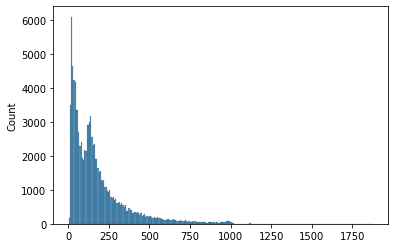

In [47]:
sns.histplot(lens)

#the model

##create vectorizer

In [52]:
def custom_standardization(input_data):
  data = tf.strings.lower(input_data)
  data = tf.strings.regex_replace(data, '<br />', ' ')
  for i in stopwords.words('english'):
    data = tf.strings.regex_replace(data, r'\b{}\b'.format(i), '')
  return tf.strings.regex_replace(data,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [53]:
# Make a text-only dataset (without labels), then call adapt to make vocabulary
train_text = raw_train_ds.map(lambda x, y: x)
train_text.cache().prefetch(buffer_size=AUTOTUNE)
# type(train_text)
# type(raw_train_ds)

<PrefetchDataset element_spec=TensorSpec(shape=(None,), dtype=tf.string, name=None)>

In [54]:
for text_batch in train_text.take(1):
  for i in range(5):
    print("Review", text_batch.numpy()[i])
#     print("Label", label_batch.numpy()[i])



Review b"Very Strong Season 2 I enjoyed the first season, but I must say I think season 2 is even stronger. Ricky does a great job as both writer, actor and director and brings out the best in a superb supporting cast. If there was one thing I'd change, I'd like to hear him talk about himself less with other people and speak more in the third person, but other than that it's pretty hard to fault this funny yet emotional comedy."
Review b'Icelandic detectives? I know Iceland is a small country and police do things a bit different in Europe but c\'mon... The incompetent police work robs this show of any believability.\n1st Detective: "hey we got two persons of interest we need to talk with and one of them could possibly be the serial killer, which one should we visit first?"\n2nd Detective: "lets split up!"'
Review b"Good but I'm guessing that as a 62 year old white woman I'm not the target demographic but I enjoyed this show. Good to see others perspectives and loved the wry humor. More

In [55]:
def make_vectorize_layer(max_features, sequence_length):

    vectorize_layer = layers.TextVectorization(
    standardize='lower_and_strip_punctuation',
    # standardize=custom_standardization,
    max_tokens=max_features, #vocabulary size
    output_mode='int',
    output_sequence_length=sequence_length)

    vectorize_layer.adapt(train_text)

    # Pickle the config and weights
    file = open(f'ds7718-final_project/checkpoints/vectorization layer/vect_layer_fetures{max_features}_seq{sequence_length}.obj', 'wb') 
    pickle.dump({'config': vectorize_layer.get_config(),
                'weights': vectorize_layer.get_weights()}
                , file )

    return vectorize_layer


In [56]:
def load_vectorize_layer(max_features, sequence_length):
  from_disk =  pickle.load(open(f'ds7718-final_project/checkpoints/vectorization layer/vect_layer_fetures{max_features}_seq{sequence_length}.obj', 'rb') )
  new_vectorize_layer = layers.TextVectorization.from_config(from_disk['config'])
  # You have to call `adapt` with some dummy data (BUG in Keras)
  # new_v.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
  new_vectorize_layer.set_weights(from_disk['weights'])

  return new_vectorize_layer


In [57]:
# started from:
# max_features = 10000
# sequence_length = 250

# finised with
max_features = 10000
sequence_length = 400

In [58]:
# vectorize_layer = make_vectorize_layer(max_features, sequence_length)

In [59]:
vectorize_layer = load_vectorize_layer(max_features, sequence_length)

In [60]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label


In [61]:
vectorize_layer.get_vocabulary()[:5]

['', '[UNK]', 'the', 'and', 'a']

In [62]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [63]:
# for text_batch, label_batch in train_ds.take(1):
#   for i in range(3):
#     print("Review", text_batch.numpy()[i])
#     print("Label", label_batch.numpy()[i])


In [64]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

##create the model - skip to reload model from disk

In [62]:
embedding_dim = 16
# embedding_dim = 64

In [49]:
model = tf.keras.Sequential([
  layers.Embedding(max_features , embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
    
  # layers.Dense(10, activation='softmax')])
  layers.Dense(3, activation='softmax')])

model.summary()
# (1000, 250, 16)
# (1000, 16)


# kernel_regularizer=tf.keras.regularizers.l2(0.01)),

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 3)                 51        
                                                                 
Total params: 160,051
Trainable params: 160,051
Non-trainable params: 0
_________________________________________________________________


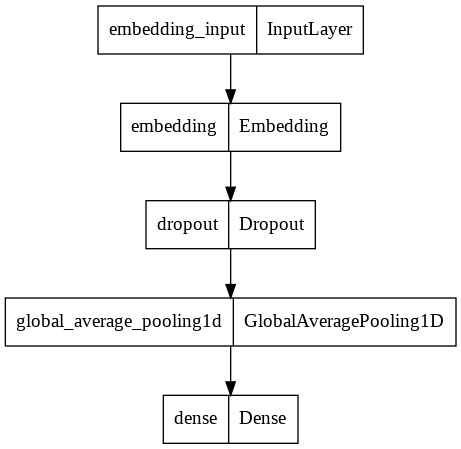

In [50]:
tf.keras.utils.plot_model(model)

## Loss function and optimizer - skip to reload model from disk

A model needs a loss function and an optimizer for training. Since this is a sparse classification problem and the model outputs a probability (a multi-unit layer with a softmax activation), you'll use `losses.SparseCategoricalCrossentropy` loss function.

Now, configure the model to use an optimizer and a loss function:

In [51]:
# with:
# max_features = 10000
# sequence_length = 250

##### w/o LearningRateScheduler:

# optimizer='adam'                                                     ### val_loss: 1.6452 - val_accuracy: 0.4197

# optimizer='adadelta'                                                 ### val_loss: 1.0903 - val_accuracy: 0.4005

# optimizer = tf.keras.optimizers.SGD(lr=0.01)                         ### val_loss: 1.2457 - val_accuracy: 0.3715

## This implementation of RMSprop uses plain momentum, not Nesterov momentum.
## The centered version additionally maintains a moving average of the gradients, and uses that average to estimate the variance.
# optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4)            ### val_loss: 0.8589 - val_accuracy: 0.6008



##### with LearningRateScheduler:

optimizer='adam'                                                     ### val_loss: 0.6714 - val_accuracy: 0.7149

# optimizer='adadelta'                                                 ### val_loss: 1.0936 - val_accuracy: 0.4005

# optimizer = tf.keras.optimizers.SGD(lr=0.01)                         ### val_loss: 1.2879 - val_accuracy: 0.3717

# optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4)            ### val_loss: 0.8255 - val_accuracy: 0.6798







model.compile(loss=losses.SparseCategoricalCrossentropy(),
              optimizer=optimizer,
              metrics=["accuracy"])


## Train the model - skip to reload model from disk

You will train the model by passing the `dataset` object to the fit method.

In [47]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [48]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stopping = tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)

In [59]:
epochs = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[early_stopping
               , lr_scheduler
               ],
    epochs=epochs)

Epoch 1/100
1422/1422 [==============================] - 170s 119ms/step - loss: 0.6571 - accuracy: 0.7237 - val_loss: 0.6647 - val_accuracy: 0.7206 - lr: 1.6616e-06
Epoch 2/100
1422/1422 [==============================] - 170s 119ms/step - loss: 0.6571 - accuracy: 0.7237 - val_loss: 0.6647 - val_accuracy: 0.7206 - lr: 1.6616e-06
Epoch 3/100
1422/1422 [==============================] - 169s 119ms/step - loss: 0.6570 - accuracy: 0.7237 - val_loss: 0.6647 - val_accuracy: 0.7206 - lr: 1.6616e-06
Epoch 3: early stopping


In [ ]:
# model_loc = 'ds7718-final_project/checkpoints/models/3-classes/adam_features10000_sequence250_AveragePooling'
# model_loc = 'ds7718-final_project/checkpoints/models/3-classes/adadelta_features10000_sequence250_AveragePooling'
# model_loc = 'ds7718-final_project/checkpoints/models/3-classes/SGD_features10000_sequence250_AveragePooling'
# model_loc = 'ds7718-final_project/checkpoints/models/3-classes/RMSprop_features10000_sequence250_AveragePooling'

# model_loc = 'ds7718-final_project/checkpoints/models/3-classes/adam_lr_features10000_sequence250_AveragePooling'. ### best
# model_loc = 'ds7718-final_project/checkpoints/models/3-classes/adadelta_lr_features10000_sequence250_AveragePooling'
# model_loc = 'ds7718-final_project/checkpoints/models/3-classes/SGD_lr_features10000_sequence250_AveragePooling'
# model_loc = 'ds7718-final_project/checkpoints/models/3-classes/RMSprop_lr_features10000_sequence250_AveragePooling'



we choose the adam with learning rate scheduler.

val_loss: 0.6714 - val_accuracy: 0.7149

now play with features and sequence

In [59]:
# model_loc = 'ds7718-final_project/checkpoints/models/3-classes/adam_lr_features50000_sequence250_AveragePooling'
# val_loss: 1.8143 - val_accuracy: 0.3938

# model_loc = 'ds7718-final_project/checkpoints/models/3-classes/adam_lr_features5000_sequence250_AveragePooling'
# val_loss: 0.6966 - val_accuracy: 0.7013

# model_loc = 'ds7718-final_project/checkpoints/models/3-classes/adam_lr_features10000_sequence50_AveragePooling'
# val_loss: 0.7314 - val_accuracy: 0.6707

model_loc = 'ds7718-final_project/checkpoints/models/3-classes/adam_lr_features10000_sequence400_AveragePooling'
#  val_loss: 0.6647 - val_accuracy: 0.7206


In [ ]:
# model.save(model_loc)

lets play with model parts

In [49]:
embedding_dim = 64 # instead of 16

In [ ]:
model = tf.keras.Sequential([
  layers.Embedding(max_features , embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  
  layers.Dense(3, activation='softmax')])

model.summary()

In [53]:

optimizer='adam'                

model.compile(loss=losses.SparseCategoricalCrossentropy(),
              optimizer=optimizer,
              metrics=["accuracy"])


In [ ]:
epochs = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[early_stopping
               , lr_scheduler
               ],
    epochs=epochs)

In [57]:
# model_loc = 'ds7718-final_project/checkpoints/models/3-classes/embedding_64_adam_lr_features10000_sequence400_AveragePooling'
# val_loss: 0.6646 - val_accuracy: 0.7206

In [56]:
# model.save(model_loc)

INFO:tensorflow:Assets written to: ds7718-final_project/checkpoints/models/3-classes/embedding_64_adam_lr_features10000_sequence400_AveragePooling_/assets


## Evaluate the model - skip to reload model from disk

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [58]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

305/305 [==============================] - 422s 1s/step - loss: 0.6645 - accuracy: 0.7209
Loss:  0.6645269989967346
Accuracy:  0.7208604216575623


## Load the chosen model from disk

In [50]:
model_loc = 'ds7718-final_project/checkpoints/models/3-classes/adam_lr_features10000_sequence400_AveragePooling'
model = keras.models.load_model(model_loc)

## Build an export model

In [65]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Lambda(lambda x: tf.keras.backend.cast(tf.keras.backend.argmax(x), dtype='int32'))
])


In [66]:
export_model.compile(loss=losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=tf.metrics.SparseCategoricalAccuracy())

In [ ]:
# export_model.predict(b'the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great the movie was great ')

check some examples

In [67]:
export_model.predict((b'the movie was really good! I would recommend this movie to all my friends',))[0]

2

In [65]:
export_model.predict((b'the movie was just ok, i will not see it again',))[0]

1

In [67]:
export_model.predict((b'the movie was the worse movie ever!',))[0]

0

##confusion matrix

Compute confusion matrix to evaluate the accuracy of a classification

In [76]:
y_pred = []
y_test = []
for text_batch, label_batch in raw_test_ds.take(1):  # for analytics, 1024 records
  for i in range(batch_size):
    y_pred.append(export_model.predict((text_batch.numpy()[i],))[0])
    y_test.append(label_batch.numpy()[i])




In [77]:
y_labels = [0,1,2]
y_labels.sort()
y_labels

[0, 1, 2]

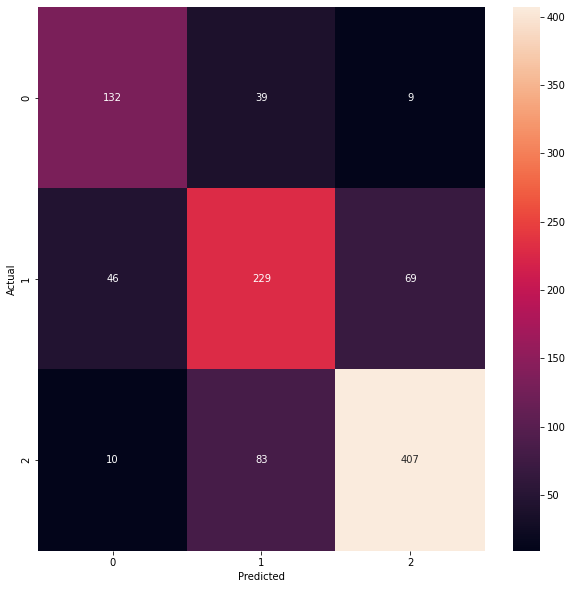

In [78]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=y_labels, yticklabels=y_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# we can see that predict is mostly near the actual

##some example for mistaking

In [84]:
y_pred_np = np.array(y_pred) 
y_pred_np

array([0, 1, 0, ..., 2, 0, 1], dtype=int32)

In [85]:
y_test_np = np.array(y_test)
y_test_np

array([1, 2, 1, ..., 2, 0, 1])

check missed predictions

In [86]:
mask = np.logical_and(y_test_np == 0, y_pred_np == 2)

In [88]:
text_batch.numpy()[mask]

array([b'Very predictible sweet movie A very predictible sweet little movie. It has the pace of a Christian movie.',
       b"Focus issues Learn how to rack focus and teach actors not to step on each other's lines. Brutal.",
       b'WINNERS THEN, MADE US LOSERS NOW Great victory 40 years ago, complete losers now. Must have taken one too many body checks.',
       b"I died of boredom halfway through The movie feels as it's been written by a 18 year old emo kid.\neverything is like, super meaningful, and like deep and stuff.every detail is like super retro, and the girl has great hair.",
       b"Father of Nepotism His life's only motive is to launch talentless nepokids.",
       b'Warning Spoilers American Horror Story had a great start with a solid season 1. Afterwards things went town hill. Season 1 was like the Shining. The rest was like Disney Star Wars. You can see a huge shift from season 1 writing and the rest of the seasons.',
       b'"This Goes on into Perpetuity" Malloy (Fra

In [91]:
mask = np.logical_and(y_test_np == 2, y_pred_np == 0)

In [92]:
text_batch.numpy()[mask]

array([b'Finally non quirky sitcom! Im sick of quirky sitcom where the character is talking nonsense in the middle of their conversation, or doing unbelievable stupid things, this not it. I love it!',
       b'Wonderful /Unique I am like movie fanatci and seeing movie since 2008 but never write any reviews.\nThis movie is so powerful that force me to write some line to make recognition of this movie.\nI have are here to decide to watch it then dont waste time. the movie is about atheist person who is looking for scientific reason for .....Just watch it',
       b'Shark Tank The answer to the rising toilet fiasco involves a trip to Shark Tank, the popular TV show where entrepreneurs attempt to sell an idea. But the greatest part of this episode involves Frankie and Grace trying to get their prototype toilet back after accidentally leaving it on a curb while a flat tire was being repaired. There are other issues with Sol and Robert as Robert is going to attempt to put the proper money ba